# Federated Learning

Resource: https://www.deeplearning.ai/short-courses/intro-to-federated-learning/

### Simulate training process on different datasets with "missing" digits

In [1]:
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=0, std=1),
])

trainset = datasets.MNIST(
    root="../data/",
    download=True,
    train=True,
    transform=transform,
    target_transform=None,
)

In [2]:
# Split data into three parts
import torch
from torch.utils.data import random_split

total_length= len(trainset)
split_size = total_length // 3
torch.manual_seed(42)

part_1, part_2, part_3 = random_split(trainset, [split_size] * 3)

In [3]:
# Delete specific digits from training sets
from torch.utils.data import Subset

def exclude_digits(dataset, exclude_digits):
    including_indices = [
        idx for idx in range(len(dataset)) if dataset[idx][1] not in exclude_digits
    ]
    
    return Subset(dataset, indices=including_indices)

part_1 = exclude_digits(part_1, exclude_digits=[1, 3, 7])
part_2 = exclude_digits(part_2, exclude_digits=[2, 5, 8])
part_3 = exclude_digits(part_3, exclude_digits=[4, 6 ,9])

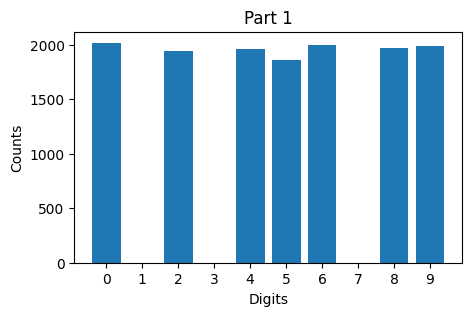

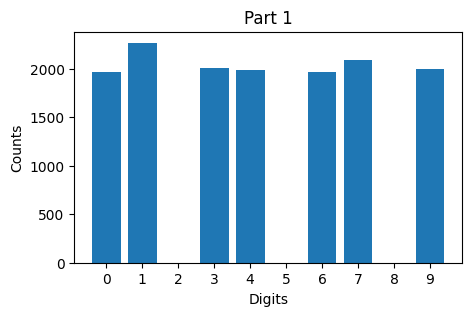

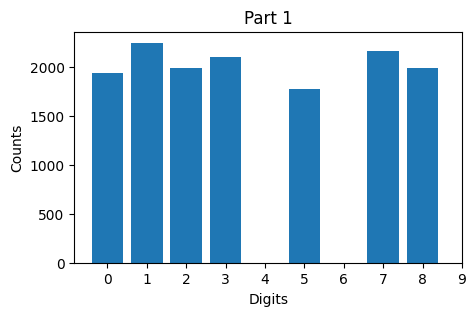

In [4]:
# Visualize distributions
import numpy as np
import matplotlib.pyplot as plt

def plot_distribution(dataset, title):
    labels = [data[1] for data in dataset]
    unique_labels, label_counts = torch.unique(torch.tensor(labels), return_counts=True)
        
    plt.figure(figsize=(5, 3))
    plt.bar(x=unique_labels, height=label_counts)
    plt.title(title)
    plt.xlabel("Digits")
    plt.ylabel("Counts")
    plt.xticks(np.arange(10))
    plt.show()

plot_distribution(part_1, "Part 1")
plot_distribution(part_2, "Part 1")
plot_distribution(part_3, "Part 1")

In [5]:
# Train models
import torch.nn as nn
from torch.utils.data import DataLoader

class Model(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_1 = nn.Linear(784, 128)
        self.relu = nn.ReLU()
        self.linear_2 = nn.Linear(128, 10)
    
    def forward(self, x):
        return self.linear_2(
            self.relu(
                self.linear_1(
                    self.flatten(x)
                )
            )
        )

def train_model(model, train_set):
    BATCH_SIZE = 32
    NUM_EPOCHS = 5
    
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(
        params=model.parameters(),
        lr = 0.01,
    )
    
    loader = DataLoader(
        dataset=train_set,
        batch_size=BATCH_SIZE,
        shuffle=True,
    )
    
    model.train()
    
    for epoch in range(NUM_EPOCHS):
        total_loss = 0
        
        for X, y in loader:
            y_pred = model(X)
            
            loss = loss_fn(y_pred, y)
            total_loss += loss.item()
            
            optimizer.zero_grad()
            
            loss.backward()
            
            optimizer.step()
    
        print(f"Epoch: {epoch} | Loss: {total_loss / len(loader)}")
    
    print("Trainig completed...\n")

In [6]:
model_1 = Model()
train_model(model_1, part_1)

model_2 = Model()
train_model(model_2, part_1)

model_3 = Model()
train_model(model_3, part_1)

Epoch: 0 | Loss: 1.395572882752086
Epoch: 1 | Loss: 0.5616558927782747
Epoch: 2 | Loss: 0.39006808996850323
Epoch: 3 | Loss: 0.32872846218389135
Epoch: 4 | Loss: 0.295739340158396
Trainig completed...

Epoch: 0 | Loss: 1.4490871369492175
Epoch: 1 | Loss: 0.5722171773051107
Epoch: 2 | Loss: 0.39605233296751974
Epoch: 3 | Loss: 0.335979075972424
Epoch: 4 | Loss: 0.30107306267979533
Trainig completed...

Epoch: 0 | Loss: 1.4175367183463519
Epoch: 1 | Loss: 0.5557506751875545
Epoch: 2 | Loss: 0.3897400051008823
Epoch: 3 | Loss: 0.3262198866496599
Epoch: 4 | Loss: 0.29548648008426953
Trainig completed...



In [7]:
# Download MNIST test dataset
from torchvision import datasets, transforms

testset = datasets.MNIST(
    root="../data/",
    download=True,
    train=False,
    transform=transform,
    target_transform=None,
)

In [8]:
def include_digits(dataset, included_digits):
    including_indices = [
        idx for idx in range(len(dataset)) if dataset[idx][1] in included_digits
    ]
    return torch.utils.data.Subset(dataset, including_indices)

testset_137 = include_digits(testset, included_digits=[1, 3, 7])
testset_258 = include_digits(testset, included_digits=[2, 5, 8])
testset_469 = include_digits(testset, included_digits=[4, 6, 9])

In [9]:
# Evaluate models
def evaluate_model(model, test_set):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0

    loader = DataLoader(test_set, batch_size=64, shuffle=False)
    loss_fn = nn.CrossEntropyLoss()

    with torch.no_grad():
        for X, y in loader:
            y_pred = model(X)
            
            _, predicted = torch.max(y_pred.data, 1)
            
            total += y.size(0)
            
            correct += (predicted == y).sum().item()

            loss = loss_fn(y_pred, y)
            
            total_loss += loss.item()

    accuracy = correct / total
    average_loss = total_loss / len(loader)

    return average_loss, accuracy

In [10]:
_, accuracy1 = evaluate_model(model_1, testset)
_, accuracy1_on_137 = evaluate_model(model_1, testset_137)
print(
    f"Model 1:\nTest Accuracy on all digits: {accuracy1:.4f}, "
    f"Test Accuracy on [1,3,7]: {accuracy1_on_137:.4f}\n"
)

_, accuracy2 = evaluate_model(model_2, testset)
_, accuracy2_on_258 = evaluate_model(model_2, testset_258)
print(
    f"Model 2:\nTest Accuracy on all digits: {accuracy2:.4f}, "
    f"Test Accuracy on [2,5,8]: {accuracy2_on_258:.4f}\n"
)

_, accuracy3 = evaluate_model(model_3, testset)
_, accuracy3_on_469 = evaluate_model(model_3, testset_469)
print(
    f"Model 3:\nTest Accuracy on all digits: {accuracy3:.4f}, "
    f"Test Accuracy on [4,6,9]: {accuracy3_on_469:.4f}\n"
)

Model 1:
Test Accuracy on all digits: 0.6239, Test Accuracy on [1,3,7]: 0.0000

Model 2:
Test Accuracy on all digits: 0.6202, Test Accuracy on [2,5,8]: 0.8799

Model 3:
Test Accuracy on all digits: 0.6209, Test Accuracy on [4,6,9]: 0.9223



In [11]:
# Create confusion matrics
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, testset, title):
    y_true = []
    y_pred = []

    for X, y in testset:
        logit = model(X.unsqueeze(0))  # Add batch dimension
        _, pred = torch.max(logit, 1)

        y_true.append(y)
        y_pred.append(pred.item())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", linewidths=0.5)
    plt.title(title)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

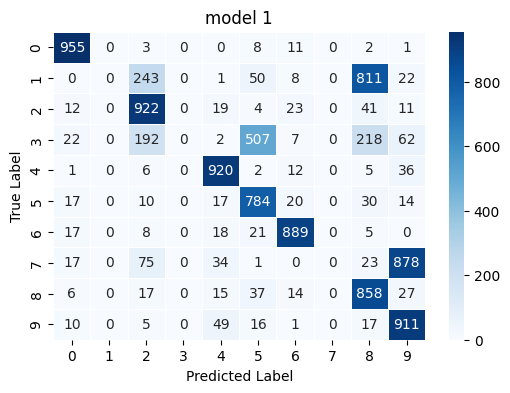

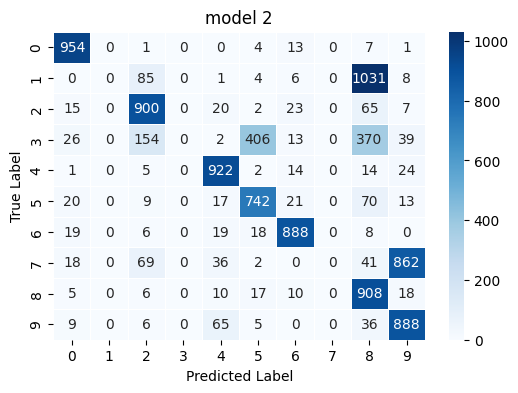

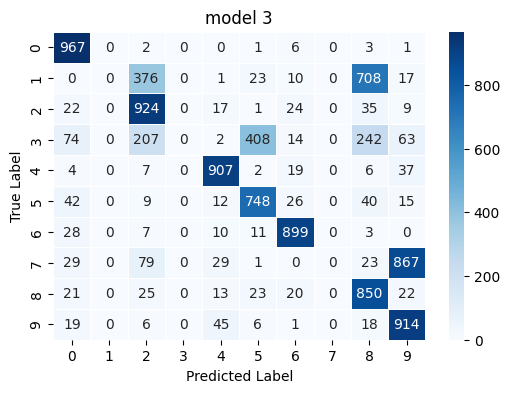

In [12]:
plot_confusion_matrix(model_1, testset, "model 1")
plot_confusion_matrix(model_2, testset, "model 2")
plot_confusion_matrix(model_3, testset, "model 3")

### Create federeted learning process

In [13]:
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import ndarrays_to_parameters, Context
from flwr.server import ServerApp, ServerConfig
from flwr.server import ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation

/Users/mchojna/Documents/GitHub/llm-playground/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-08-04 17:37:15,643	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [14]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

In [15]:
trainset = datasets.MNIST(
    "../data/MNIST_data/",
    download=True,
    train=True,
    transform=transform
)

In [16]:
total_length = len(trainset)
split_size = total_length // 3

In [17]:
torch.manual_seed(42)
part_1, part_2, part_3 = random_split(trainset, [split_size] * 3)

In [18]:
part_1 = exclude_digits(part_1, exclude_digits=[1, 3, 7])
part_2 = exclude_digits(part_2, exclude_digits=[2, 5, 8])
part_3 = exclude_digits(part_3, exclude_digits=[3, 6, 9])

train_sets = [part_1, part_2, part_3]

/Users/mchojna/Documents/GitHub/llm-playground/.venv/lib/python3.11/site-packages/torchvision/datasets/mnist.py:143: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(img.numpy(), mode="L")


In [19]:
testset = datasets.MNIST(
    "../data/MNIST_data", 
    download=True,
    train=False,
    transform=transform,
)

print(f"Number of examples in `testset`: {len(testset)}")

Number of examples in `testset`: 10000


In [20]:
test_set_137 = include_digits(testset, [1, 3, 7])
test_set_258 = include_digits(testset, [2, 4, 8])
test_set_369 = include_digits(testset, [3, 5, 9])

In [21]:
# Set parameters of model
from typing import OrderedDict

def set_weights(net, parameters):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict(
        {k: torch.tensor(v) for k, v in params_dict}
    )
    net.load_state_dict(state_dict, strict=True)

In [22]:
# Retrieve parameters of the model
def get_weights(net):
    ndarrays = [
        val.cpu().numpy() for _, val in net.state_dict().items()
    ]
    return ndarrays

In [23]:
from typing import Dict
from flwr.common import NDArrays, Scalar

class FlowerClient(NumPyClient):
    def __init__(self, net, trainset, testset):
        self.net = net
        self.trainset = trainset
        self.testset = testset
    
    def fit(self, parameters, config):
        set_weights(self.net, parameters)
        train_model(self.net, self.trainset)
        return get_weights(self.net), len(self.trainset), {}
    
    def evaluate(self, parameters: NDArrays, config: Dict[str, Scalar]):
        set_weights(self.net, parameters)
        loss, accuracy = evaluate_model(self.net, self.testset)
        return loss, len(self.testset), {"accuracy": accuracy}

In [24]:
def client_fn(context: Context) -> Client:
    net = Model()
    partition_id = int(context.node_config["partition-id"])
    client_train = train_sets[int(partition_id)]
    client_test = testset
    return FlowerClient(net, client_train, client_test).to_client()

In [25]:
client = ClientApp(client_fn)

In [26]:
def evaluate(server_round, parameters, config):
    net = Model()
    set_weights(net, parameters)
    
    _, accuracy = evaluate_model(net, testset)
    _, accuracy_137 = evaluate_model(net, testset_137)
    _, accuracy_258 = evaluate_model(net, testset_258)
    _, accuracy_469 = evaluate_model(net, testset_469)
    
    print(f"Test accuracy on all digits: {accuracy:.4f}")
    print(f"Test accuracy on [1, 3, 7]: {accuracy_137:.4f}")
    print(f"Test accuracy on [2, 5, 8]: {accuracy_258:.4f}")
    print(f"Test accuracy on [4, 6, 9]: {accuracy_469:.4f}")
    
    if server_round == 3:
        plot_confusion_matrix(
            model=net,
            testset=testset,
            title="Final Global Midek"
        )

In [27]:
net = Model()
params = ndarrays_to_parameters(get_weights(net))

def server_fn(context: Context):
    strategy = FedAvg(
        fraction_fit=1.0,
        fraction_evaluate=0.0,
        initial_parameters=params,
        evaluate_fn=evaluate,
    )
    config = ServerConfig(num_rounds=3)
    
    return ServerAppComponents(
        strategy=strategy,
        config=config
    )

In [28]:
server = ServerApp(server_fn=server_fn)

INFO :      Starting Flower ServerApp, config: num_rounds=3, no round_timeout
INFO :      


INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
/Users/mchojna/Documents/GitHub/llm-playground/.venv/lib/python3.11/site-packages/torchvision/datasets/mnist.py:143: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(img.numpy(), mode="L")
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Test accuracy on all digits: 0.1267
Test accuracy on [1, 3, 7]: 0.1510
Test accuracy on [2, 5, 8]: 0.0783
Test accuracy on [4, 6, 9]: 0.0051


(ClientAppActor pid=27628) /Users/mchojna/Documents/GitHub/llm-playground/.venv/lib/python3.11/site-packages/torchvision/datasets/mnist.py:143: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
(ClientAppActor pid=27628)   img = Image.fromarray(img.numpy(), mode="L")


(ClientAppActor pid=27626) Epoch: 0 | Loss: 0.7394368689788561
(ClientAppActor pid=27628) Epoch: 3 | Loss: 0.2536823296876148 [repeated 9x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(ClientAppActor pid=27628) Trainig completed...
(ClientAppActor pid=27628) 
(ClientAppActor pid=27626) 


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=27627) 


INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Test accuracy on all digits: 0.6335
Test accuracy on [1, 3, 7]: 0.4368
Test accuracy on [2, 5, 8]: 0.6611
Test accuracy on [4, 6, 9]: 0.6762
(ClientAppActor pid=27627) Epoch: 0 | Loss: 0.29953067571000563 [repeated 6x across cluster]
(ClientAppActor pid=27627) Trainig completed... [repeated 2x across cluster]
(ClientAppActor pid=27627) Epoch: 3 | Loss: 0.2293332481323633 [repeated 9x across cluster]
(ClientAppActor pid=27627) Trainig completed...
(ClientAppActor pid=27627) 
(ClientAppActor pid=27628) 


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=27626) 


INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Test accuracy on all digits: 0.7776
Test accuracy on [1, 3, 7]: 0.5559
Test accuracy on [2, 5, 8]: 0.8326
Test accuracy on [4, 6, 9]: 0.8494
(ClientAppActor pid=27626) Epoch: 0 | Loss: 0.23017870904228022 [repeated 6x across cluster]
(ClientAppActor pid=27626) Trainig completed... [repeated 2x across cluster]
(ClientAppActor pid=27626) Epoch: 3 | Loss: 0.18490324305955233 [repeated 9x across cluster]
(ClientAppActor pid=27626) 
(ClientAppActor pid=27626) Trainig completed...
(ClientAppActor pid=27627) Trainig completed...
(ClientAppActor pid=27627) 


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=27628) 
Test accuracy on all digits: 0.8133
Test accuracy on [1, 3, 7]: 0.6785
Test accuracy on [2, 5, 8]: 0.8885
Test accuracy on [4, 6, 9]: 0.8837


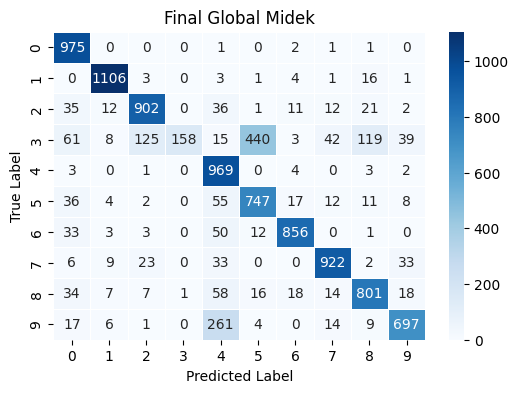

INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 3 round(s) in 67.77s
INFO :      


(ClientAppActor pid=27628) Epoch: 4 | Loss: 0.1361710442400952 [repeated 5x across cluster]
(ClientAppActor pid=27628) Trainig completed...


(ClientAppActor pid=27627) /Users/mchojna/Documents/GitHub/llm-playground/.venv/lib/python3.11/site-packages/torchvision/datasets/mnist.py:143: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15) [repeated 2x across cluster]
(ClientAppActor pid=27627)   img = Image.fromarray(img.numpy(), mode="L") [repeated 2x across cluster]


In [29]:
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=3,
)